In [2]:
import os
import torch
import numpy as np
import netCDF4 as nc
from torch.utils.data import Dataset, DataLoader
from datetime import datetime

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
class DownscalingDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, low_res_data, high_res_data, low_var_name=None, high_var_name=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            low_res_path (string): Path to the low resolution data.
            high_res_path (string): Path to the high resolution data.
        """
        self.low_res_data = low_res_data
        self.high_res_data = high_res_data
        self.low_var_name = low_var_name
        self.high_var_name = high_var_name
        
        if len(self.low_res_data) != len(self.high_res_data):
            raise ValueError("Low res and high res data must have the same length")


    def __len__(self):
        return len(self.low_res_data)

    def get_var_name(self):
        if self.low_var_name is None or self.high_var_name is None:
            warnings.warn("Some variable names are not set")
        print("Low res variable name: ", self.low_var_name)
        print("High res variable name: ", self.high_var_name)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        low_res = np.array(self.low_res_data[idx])
        high_res = self.high_res_data[idx]

        sample = {'low_res': low_res, 'high_res': high_res}

        return sample

In [4]:
def make_clean_data(out_var, in_var, year):
    if year < 2010 or year > 2020:
        print("year must be greater than 2010 and less than 2020")
        return
    in_path = 'download/era5/'+in_var+'-2010_2020.nc'
    in_data = nc.Dataset(in_path)
    
    # get the 3-hour of the start day from Unix timestamp
    start_hour = datetime(2010, 1, 1, 0).timestamp()/3600/3
    end_hour = datetime(2021, 1, 1, 0).timestamp()/3600/3
    low_hour = datetime(year, 1, 1, 0).timestamp()/3600/3
    high_hour = datetime(year+1, 1, 1, 0).timestamp()/3600/3
    start_index = int(low_hour - start_hour)
    end_index = int(high_hour - start_hour)
    in_data = in_data[in_var][start_index:end_index]
    out_data = np.load('download/cerra/' + out_var + '-' + str(year) + '.npy')

    return in_data, out_data

In [5]:
in_data, out_data = make_clean_data('si10', 'u10', 2019)
dataset = DownscalingDataset(in_data, out_data, low_var_name='u10', high_var_name='si10')
dataset.get_var_name()
print(len(dataset))
print(dataset[0]["low_res"].shape)
print(dataset[0]["high_res"].shape)

Low res variable name:  u10
High res variable name:  si10
2920
(13, 21)
(73, 101)


In [6]:
T = 1000 # I think they use 5 for evaluation. not sure about training but 5 seems low??
min_noise = 0.0001 # don't really know what to use for these values
max_noise = 0.02

In [8]:
# From youtube tutorial. Could be re-implemented but seems good to me

import torch.nn.functional as F

def linear_beta_schedule(timesteps, start, end):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
betas = linear_beta_schedule(timesteps=T, start=min_noise, end=max_noise)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # don't know why we need that
sqrt_recip_alphas = torch.sqrt(1.0 / alphas) # don't know why we need that
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # don't know why we need that

In [93]:
##########################################################################################
# Let's define the Unet
##########################################################################################

In [9]:
import torch.nn as nn

In [12]:
# This is used to get embedding of time step t to provide it as input to the model
# so that it knows how much noise it needs to remove
# From the youtube video. i didn't find any other way to do that online

import math

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time): # idk if they use the same embedding in the paper's model
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings

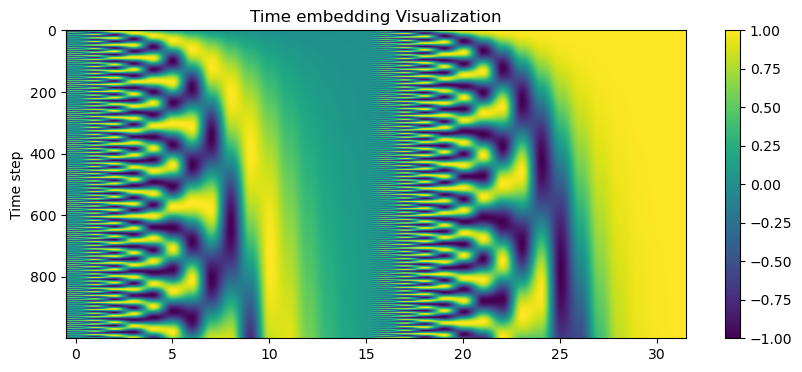

In [13]:
# Illustrating the embeddings:
import matplotlib.pyplot as plt

all_t = torch.arange(1, 1001)
test_embed = SinusoidalPositionEmbeddings(dim=32)
output = test_embed(all_t)

plt.figure(figsize=(10,4))
plt.imshow(output, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Time embedding Visualization')
plt.ylabel('Time step')
plt.show()


In [114]:
class DownBlock(nn.Module):
    '''Downsampling block used to build Unet'''
    def __init__(self, in_ch, out_ch, drop_p, time_emb_dim):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding='same')
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding='same')
        
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        
        # self.drop = nn.Dropout(p=drop_p)
        
        self.relu = nn.ReLU()
        
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        
    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        
        h = self.bnorm2(self.relu(self.conv2(h)))
        
        h = self.avgpool(h)
        
        # h = self.drop(h)     # not sure we wanna use dropout

In [115]:
class UpBlock(nn.Module):
    '''Upampling block used to build Unet'''
    def __init__(self, in_ch, out_ch, drop_p, time_emb_dim):
        super().__init__()
        
        self.upsamp = nn.Upsample(scale_factor=2, mode='bilinear')
        
        # 2*in_ch because residual connection
        self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding='same')
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding='same')
        
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        
        # self.drop = nn.Dropout(p=drop_p)
        
        self.relu = nn.ReLU()
        
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        
        
    def forward(self, x, t):
        h = self.upsamp(x)
        
        # h = self.drop(h)     # not sure we wanna use dropout
        
        h = self.bnorm1(self.relu(self.conv1(h)))
        
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        
        h = self.bnorm2(self.relu(self.conv2(h)))
        
        h = self.avgpool(h)

In [118]:
class DenoisingUnet(nn.Module):
    '''Unet architecture denoising model'''
    def __init__(self, nbr_channels, input_channels, output_channels, time_emb_dim):
        super().__init__()
        self.down_channels = tuple(nbr_channels)
        self.up_channels = tuple(nbr_channels[::-1])
        
        # Not sure this is the right way to combine the blocks but I think so because
        # they say they have 4 blocks on each side and they give 4 different numbers of
        # channels
        
        self.down0 = DownBlock(input_channels, self.down_channels[0], 0.5, time_emb_dim)
        
        self.downs = nn.ModuleList([DownBlock(self.down_channels[i], self.down_channels[i+1], 0.5, time_emb_dim) \
                                   for i in range(len(self.down_channels)-1)])
        
        self.ups = nn.ModuleList([UpBlock(self.up_channels[i], self.up_channels[i+1], 0.5, time_emb_dim) \
                                   for i in range(len(self.up_channels)-1)])
        
        self.output = UpBlock(self.up_channels[-1], output_channels, 0.5, time_emb_dim)
        
        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
    def forward(x):
        # Embed time
        t = self.time_mlp(timestep)
        
        residuals = []
        
        x = self.down0(x, t)
        residuals.append(x)
        
        for down in self.downs:
            x = down(x, t)
            residuals.append(x)
            
        for up in self.ups:
            residual_x = residuals.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
            
        residual_x = residuals.pop()
        x = torch.cat((x, residual_x), dim=1)
        x = self.output(x, t)

In [119]:
unet_channels = [64, 128, 256, 384]
input_channels = 5
output_channels = 1
time_emb_dim = 32 # I guess that's a standard value
model = DenoisingUnet(unet_channels, input_channels, output_channels , time_emb_dim)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  6690576


DenoisingUnet(
  (down0): DownBlock(
    (conv1): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (time_mlp): Linear(in_features=32, out_features=64, bias=True)
  )
  (downs): ModuleList(
    (0): DownBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (avgpool): AvgPool2d(kernel_size=2, stride=2, 

In [ ]:
##########################################################################################
# End of Unet
##########################################################################################

In [36]:
# I'm first going to try creating a data loader that uses only one image as input
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
batch_size = 8 # from paper
epochs = 200 # from paper
optimizer = optim.AdamW(model.parameters(), lr=1e-04, weight_decay=1e-05)
up_shape = dataset[0]["high_res"].shape

In [ ]:
data_loader = DataLoader(dataset, batch_size= batch_size, shuffle=True)

In [95]:
def callback_lr_wd(optimizer, epoch, num_epochs):
    '''Callback function that adjusts both the learning rate and weight decay'''
    lr = 1e-04 * (0.1 ** (epoch / num_epochs)) # Learning rate decay from 1e-04 to 1e-05
    wd = 1e-05 * (0.1 ** (epoch / num_epochs)) # Weight decay decay from 1e-05 to 1e-06
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        param_group['weight_decay'] = wd

In [ ]:
# Let's try to implement the parts of the training loop before combining everything together
import torch.nn.functional as F

for epoch in num_epochs:
    callback_lr_wd(optimizer, epoch, num_epochs)

    for i, batch in enumerate(data_loader):
        optimizer.zero_grad()

        low_res_imgs = batch["low_res"]
        low_res_imgs = low_res_imgs.unsqueeze(1) # because one channel

        # upsample to match high res shape
        upsampled = F.interpolate(low_res_imgs, size=up_shape, mode='bilinear')


        t = torch.randint(0, T, (batch_size,), device="cpu").long() # will need to change device

        # apply noise
        noisy_x, noise = forward_diffusion_sample(upsampled, t)

        noise_pred = model(noisy_x, t) # model is denoising unet

        loss = F1.loss(noise, noise_pred) # is that actually the loss we have to use?
        # doing that, we don't make use of the true high resolution data

        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0:
        print(f"Epoch = {epoch+1}/{num_epochs}.") 
        # What measure could we use to evaluate our training?
        # I guess the loss but it's strange in this case no?

In [ ]:
# Permet de visualiser les différents inputs, etc.
import matplotlib.pyplot as plt

def plot_windspeeds(windspeeds):
    """
    Plot windspeeds
    
    Parameters:
        windspeeds (torch.Tensor): Tensor representing windspeeds in a grid.
    """
    # Convert the windspeeds tensor to a NumPy array
    windspeeds_array = windspeeds.numpy()

    # Plot the windspeeds using imshow
    plt.figure(figsize=(10, 6))
    plt.imshow(windspeeds_array, cmap='viridis', origin='lower')
    plt.colorbar(label='Windspeed')
    plt.title('Windspeeds in Grid')
    plt.xlabel('Horizontal Index')
    plt.ylabel('Vertical Index')
    plt.show()

for i, batch in enumerate(data_loader):
    low_res_imgs = batch["low_res"]
    print("Low resolution input:")
    plot_windspeeds(low_res_imgs[0,:,:])
    low_res_imgs = low_res_imgs.unsqueeze(1) # because one channel
    
    # upsample to match high res shape
    upsampled = F.interpolate(low_res_imgs, size = up_shape, mode = 'bilinear')
    
    print("Upsampled low resolution input:")
    plot_windspeeds(upsampled[0,:,:,:].squeeze())
    
    print("True high resolution:")
    high_res_imgs = batch["high_res"]
    plot_windspeeds(high_res_imgs[0,:,:])
    
    t = torch.randint(0, T, (batch_size,), device="cpu").long() # will need to change device
    
    # apply noise
    noisy_x, noise = forward_diffusion_sample(upsampled, t)
    print("After applying noise:")
    plot_windspeeds(noisy_x[0,:,:,:].squeeze())
    
    break